In [1]:
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2


In [2]:
REPO_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan')
DATA_DIR= os.path.join(os.environ['HOME'],
                       'mydata')

In [3]:
from astrometry.util.fits import fits_table, merge_tables
from obiwan.common import fits2pandas

In [4]:
ccds= fits_table(os.path.join(DATA_DIR,
                 '1741p242','dr5/legacysurvey-1741p242-ccds.fits'))
df=fits2pandas(ccds)
df['seeing']=df['fwhm']*0.262
(df.loc[np.argsort(df['ccdnmatch'])[::-1],
       ['expnum','ccdname','seeing','ccdnmatch','image_filename']]
   .to_csv('df.csv'))
!head df.csv

,expnum,ccdname,seeing,ccdnmatch,image_filename
12,511967,S17,0.889886796474,47,decam/DECam_CP/CP20160107/c4d_160116_084245_oki_z_v1.fits.fz     
14,432018,S17,1.10720980167,47,decam/DECam_CP/CP20150407/c4d_150412_031122_ooi_g_v1.fits.fz     
13,432019,S17,0.90438747406,44,decam/DECam_CP/CP20150407/c4d_150412_031257_ooi_r_v1.fits.fz     
18,425662,S16,1.23162901402,43,decam/DECam_CP/CP20150326/c4d_150329_031648_ooi_z_v1.fits.fz     
1,432018,S5 ,1.08038723469,43,decam/DECam_CP/CP20150407/c4d_150412_031122_ooi_g_v1.fits.fz     
9,630980,S16,0.835699975491,43,decam/DECam_CP/CP20170316/c4d_170317_044025_oki_z_v1.fits.fz     
25,630980,S20,0.839677155018,43,decam/DECam_CP/CP20170316/c4d_170317_044025_oki_z_v1.fits.fz     
17,432018,S11,1.0755007267,42,decam/DECam_CP/CP20150407/c4d_150412_031122_ooi_g_v1.fits.fz     
15,511967,S11,0.874530553818,41,decam/DECam_CP/CP20160107/c4d_160116_084245_oki_z_v1.fits.fz     


In [5]:
import fitsio
hdu= fitsio.FITS(os.path.join(DATA_DIR,
                 '1741p242','ccds_decam',
                 'c4d_160116_084245_oki_z_v1_S17.fits'))
hdu


  file: /home/kaylan/mydata/1741p242/ccds_decam/c4d_160116_084245_oki_z_v1_S17.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      IMAGE_HDU       S17

In [6]:
img= hdu[1].read()

In [147]:
def plot_image(ax,image,q=None,flip_xy=True):
    if q is None:
        q=[0.5,99.5]
    vmin=np.percentile(image,q=q[0]);vmax=np.percentile(image,q=q[1])
    if flip_xy:
        ax.imshow(image.T, interpolation='none', origin='lower',
                  cmap='gray',vmin=vmin,vmax=vmax)
    else:
        ax.imshow(image.T, interpolation='none',
                  cmap='gray',vmin=vmin,vmax=vmax)
    ax.tick_params(direction='out')

def plot_xy(ax,xs=None,ys=None,
            color='y',r_pixels=3.5/0.262,
            flip_xy=True):
    """
    xs,ys: pixel positions, array like
    """
    from matplotlib.patches import Circle,Wedge
    from matplotlib.collections import PatchCollection
    dr= r_pixels/ 20
    # img transpose used, so reverse x,y
    #patches=[Wedge((x,y), r_pixels + dr, 0, 360,dr) 
    if flip_xy:
        patches=[Wedge((y, x), r_pixels + dr, 0, 360,dr)
                 for x,y in zip(xs, ys) ]
    else:
        patches=[Wedge((x, y), r_pixels + dr, 0, 360,dr)
                 for x,y in zip(xs, ys) ]
    coll = PatchCollection(patches, color=color) #,alpha=1)
    ax.add_collection(coll)
    
def justInSlice(x,y,xslc,yslc):
    """Returns x,y positions just in image slice()"""
    keep= ((x >= xslc.start) & 
           (x <= xslc.stop) &
           (y >= yslc.start) & 
           (y <= yslc.stop))
    return x[keep],y[keep]

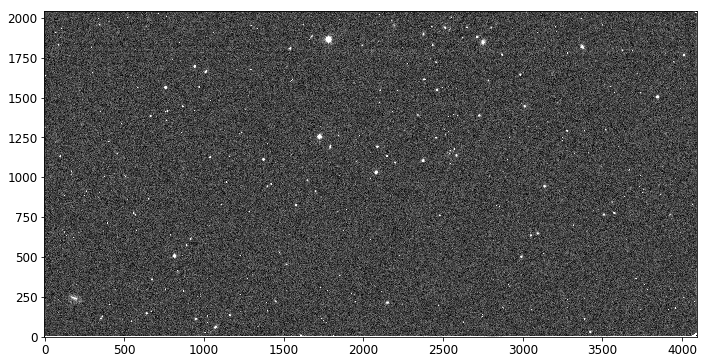

In [8]:
fix,ax=plt.subplots(figsize=(12,6))
plot_image(ax,img)

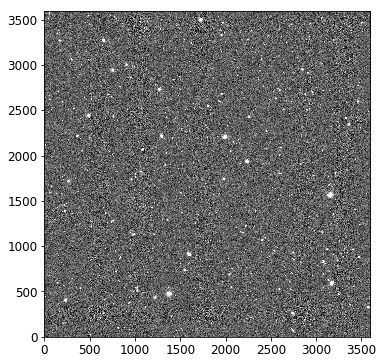

In [11]:
dr5_z= fitsio.FITS(os.path.join(DATA_DIR,
                 '1741p242','dr5',
                 'legacysurvey-1741p242-image-z.fits.fz'))[1].read()
fix,ax=plt.subplots(figsize=(12,6))
plot_image(ax,dr5_z)

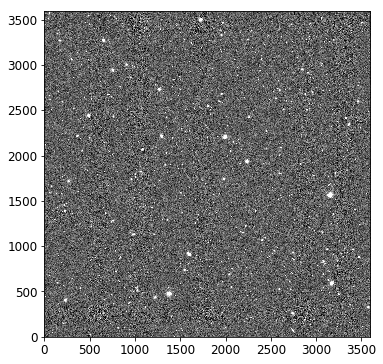

In [12]:
obi_z= fitsio.FITS(os.path.join(DATA_DIR,
                 '1741p242','rs0/coadd',
                 'legacysurvey-1741p242-image-z.fits.fz'))[1].read()
fix,ax=plt.subplots(figsize=(12,6))
plot_image(ax,obi_z)

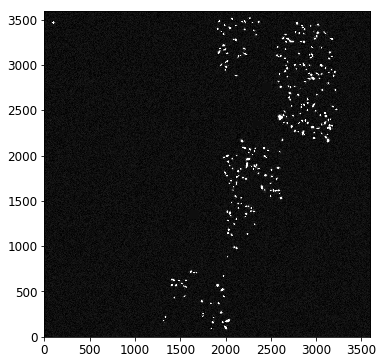

In [13]:
fix,ax=plt.subplots(figsize=(12,6))
diff= obi_z-dr5_z
plot_image(ax,diff)

In [14]:
simcat=fits_table(os.path.join(DATA_DIR,
                 '1741p242','rs0/obiwan',
                 'simcat-elg-1741p242.fits'))
skipid=fits_table(os.path.join(DATA_DIR,
                 '1741p242','rs0/obiwan',
                 'skippedids-elg-1741p242.fits'))

In [15]:
len(simcat),len(skipid)

(282, 18)

In [16]:
simcat.get_columns()

['id',
 'seed',
 'ra',
 'dec',
 'x',
 'y',
 'gflux',
 'rflux',
 'zflux',
 'sersicn',
 'rhalf',
 'ba',
 'phi']

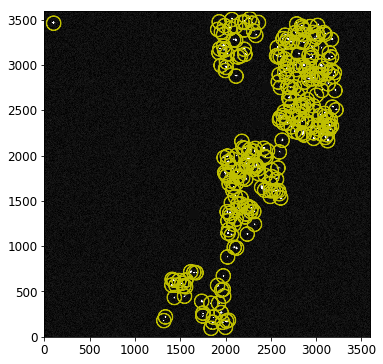

In [17]:
fix,ax=plt.subplots(figsize=(12,6))
plot_image(ax,diff)
plot_xy(ax,xs=simcat.x,ys=simcat.y,
        color='y',r_pixels=20/0.262)

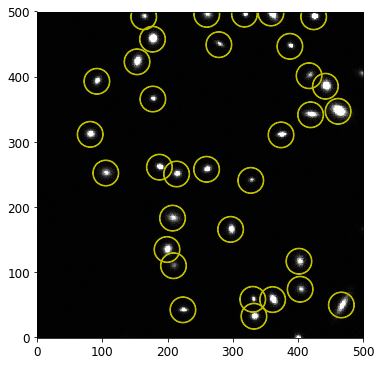

In [76]:
fix,ax=plt.subplots(figsize=(12,6))
diff= obi_z-dr5_z
xslc,yslc= slice(2500,3000), slice(2500,3000)
plot_image(ax,diff[xslc,yslc])
x,y= justInSlice(simcat.x,simcat.y,xslc,yslc)
plot_xy(ax,xs=x-xslc.start,ys=y-yslc.start,
        color='y',r_pixels=5/0.262)

(-0.01, 0.01)

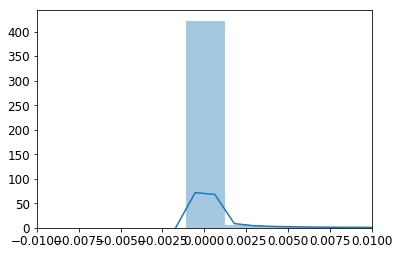

In [19]:
import seaborn as sns
sns.distplot(diff[xslc,yslc].flatten()) #,s=np.linspace(-0.01,0.01,num=100))
plt.xlim(-0.01,0.01)

In [20]:
obitractor= fits_table(os.path.join(DATA_DIR,
                 '1741p242','rs0/tractor',
                 'tractor-1741p242.fits'))

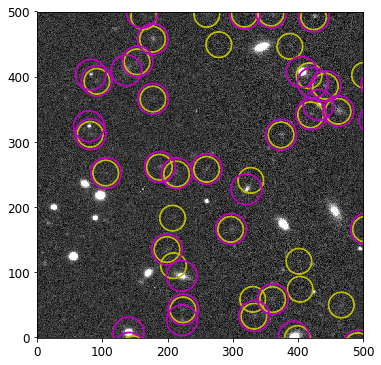

In [23]:
fix,ax=plt.subplots(figsize=(12,6))
plot_image(ax,obi_z[xslc,yslc])
# NOTE: x pixel - y slice start IS correct
plot_xy(ax,xs=simcat.x-yslc.start,ys=simcat.y-xslc.start,
        color='y',r_pixels=5/0.262)
plot_xy(ax,xs=obitractor.bx-yslc.start,ys=obitractor.by-xslc.start,
        color='m',r_pixels=6/0.262)

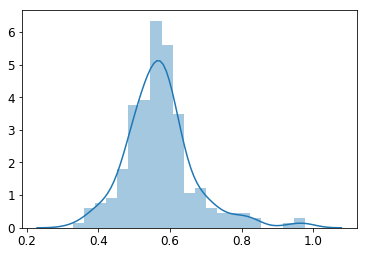

In [24]:
def not_index(indices,n):
    keep=np.ones(n,bool)
    keep[indices]=False
    return np.arange(n)[keep]

from astrometry.libkd.spherematch import match_radec
isim,itrac,d= match_radec(simcat.ra, simcat.dec, obitractor.ra, obitractor.dec,          
                          1./3600.0,nearest=True)
not_isim= not_index(isim,len(simcat))
not_itrac= not_index(itrac,len(obitractor))
sns.distplot(d*3600)

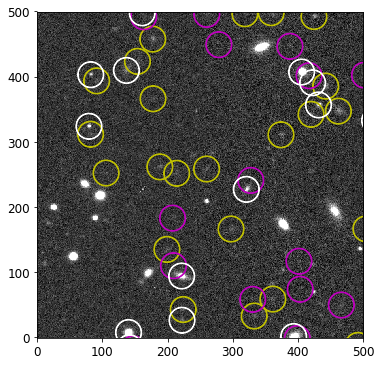

In [25]:
xslc,yslc= slice(2500,3000), slice(2500,3000)

fix,ax=plt.subplots(figsize=(12,6))
plot_image(ax,obi_z[xslc,yslc])
# Recovered
plot_xy(ax,xs=obitractor.bx[itrac]-yslc.start,ys=obitractor.by[itrac]-xslc.start,
        color='y',r_pixels=5/0.262)
# Missed 
plot_xy(ax,xs=simcat.x[not_isim]-yslc.start,ys=simcat.y[not_isim]-xslc.start,
        color='m',r_pixels=5/0.262)
# Real
plot_xy(ax,xs=obitractor.bx[not_itrac]-yslc.start,ys=obitractor.by[not_itrac]-xslc.start,
        color='w',r_pixels=5/0.262)

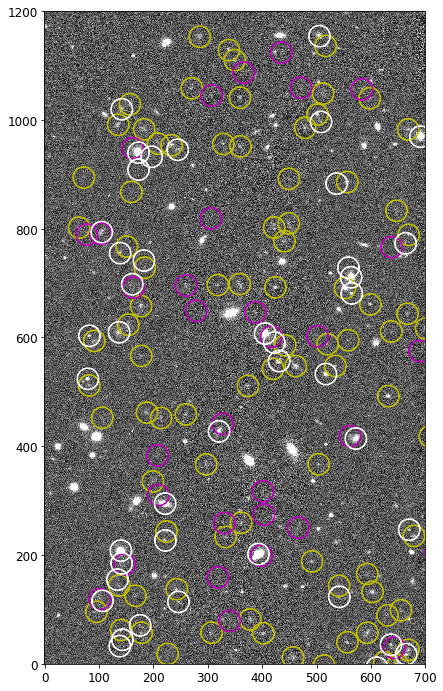

In [26]:
xslc,yslc= slice(2500,3200),slice(2300,3500) 
fig,ax=plt.subplots(figsize=(8,12))

plot_image(ax,obi_z[xslc,yslc])
# Recovered
plot_xy(ax,xs=obitractor.bx[itrac]-yslc.start,ys=obitractor.by[itrac]-xslc.start,
        color='y',r_pixels=5/0.262)
# Missed 
plot_xy(ax,xs=simcat.x[not_isim]-yslc.start,ys=simcat.y[not_isim]-xslc.start,
        color='m',r_pixels=5/0.262)
# Real
plot_xy(ax,xs=obitractor.bx[not_itrac]-yslc.start,ys=obitractor.by[not_itrac]-xslc.start,
        color='w',r_pixels=5/0.262)

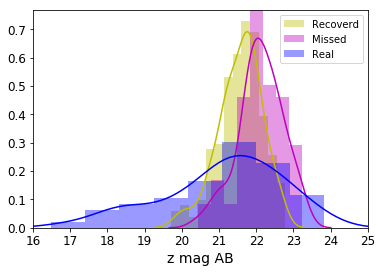

In [27]:
class Flux2mag(object):
    """convert simcat or tractor fluxes
    
    Note: both fluxes have units of nanomaggies, however simcat fluxes
    are extinction corrected while tractor fluxes do not correct for 
    extinction
    """ 
    def __init__(self):
        print('WARNING:Neither simcat or tractor fluxes are extinction corrected')
            
    def simcat(self,flux,gtZero=False):
        keep= np.ones(len(flux),bool)
        if gtZero:
            keep= (keep) & (flux > 0)
        return -2.5*np.log10(1e-9 * flux[keep])
    
    def tractor(self,flux,mw_ext,gtZero=False):
        keep= np.ones(len(flux),bool)
        if gtZero:
            keep= (keep) & (flux > 0)
        raw_mag= self.simcat(flux[keep])
        return raw_mag #- mw_ext[keep]

F= Flux2mag()
sns.distplot(F.simcat(simcat.zflux[isim]),color='y',label='Recoverd')
sns.distplot(F.simcat(simcat.zflux[not_isim]),color='m',label='Missed')
sns.distplot(F.tractor(obitractor.flux_z[not_itrac],
                       obitractor.mw_transmission_z[not_itrac],
                       gtZero=True),color='b',label='Real')
plt.xlabel('z mag AB')
plt.xlim(16,25)
plt.legend()

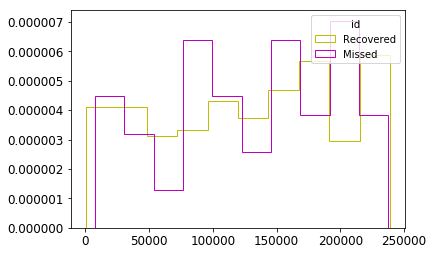

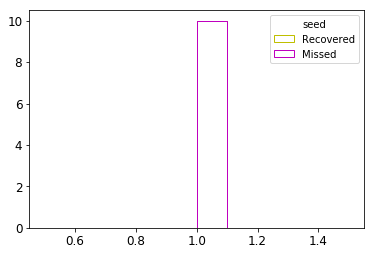

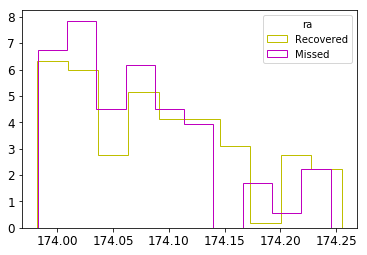

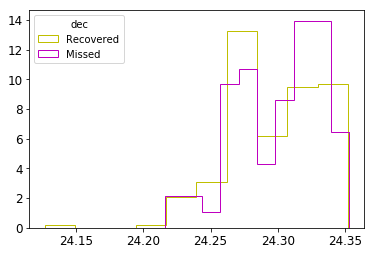

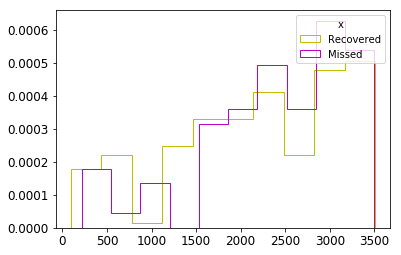

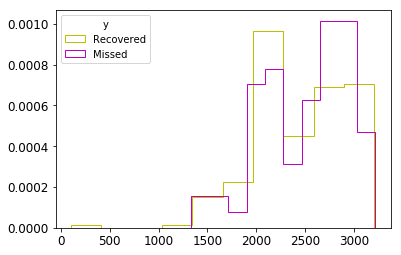

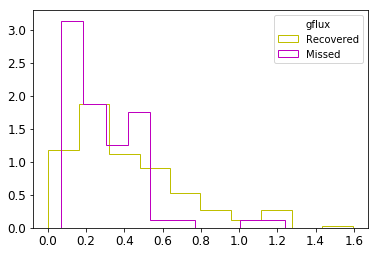

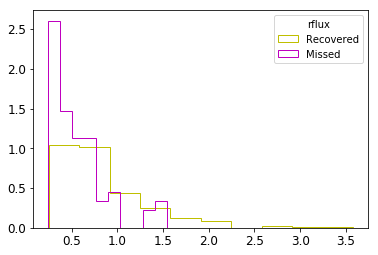

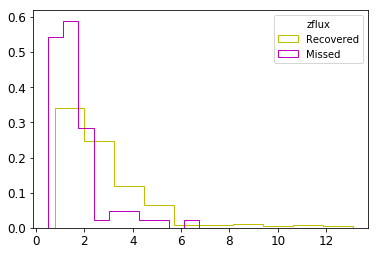

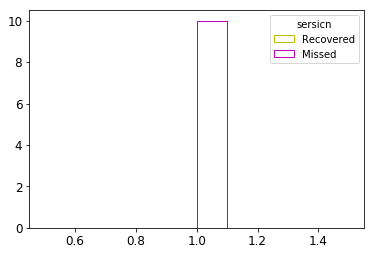

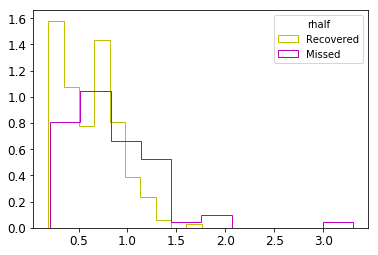

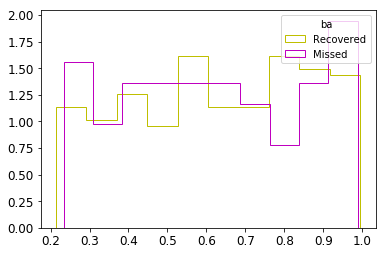

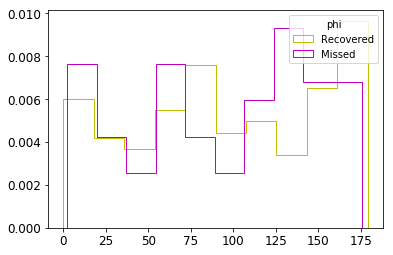

In [28]:
def myhist(x,c='b',lab='',normed=True):
    sns.reset_orig()
    _= plt.hist(x,histtype='step',normed=normed,
                color=c,label=lab)

for var in simcat.get_columns():
    for indices,lab,c in zip([isim,not_isim],['Recovered','Missed'],['y','m']):
        myhist(simcat.get(var)[indices],c=c,lab=lab)
    plt.legend(title=var)
    plt.show()

In [29]:
recovered= pd.DataFrame({
    'trac_mag':F.tractor(obitractor.flux_z[itrac],
                         obitractor.mw_transmission_z[itrac]),
    'sim_mag':F.simcat(simcat.zflux[isim])
    })
recovered['diff']= recovered['sim_mag'] - recovered['trac_mag']

# Bins over sim_mag
W=0.2
LO,HI=recovered['sim_mag'].min()-W,recovered['sim_mag'].max()
recovered['binc']= np.zeros(len(recovered))
for low,hi in zip(np.arange(LO,HI+W,W),np.arange(LO+W,HI+W*2,W)):
    recovered.loc[((recovered['sim_mag'] > low) &
                   (recovered['sim_mag'] <= hi)), 'binc']= (low+hi)/2

In [30]:
def get_q25(x):
    return np.percentile(x,q=25)

def get_q75(x):
    return np.percentile(x,q=75)

q25= recovered.groupby('binc').agg(get_q25)
q50= recovered.groupby('binc').agg(np.median)
q75= recovered.groupby('binc').agg(get_q75)
q75.head()

sim_mag   trac_mag      diff
binc                                     
19.607456  19.707456  19.647871  0.059585
20.007456  20.005220  19.994026  0.008645
20.207456  20.207467  20.315403 -0.085111
20.407456  20.424951  20.493267  0.018075
20.607456  20.670790  20.695587  0.021018

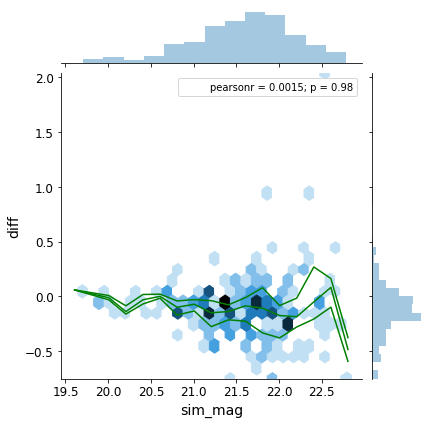

In [31]:
g = sns.jointplot(x="sim_mag", y="diff", data=recovered,
                  kind='hex')
g.ax_joint.plot(q25.index,q25['diff'],'g-')
g.ax_joint.plot(q50.index,q50['diff'],'g-')
g.ax_joint.plot(q75.index,q75['diff'],'g-')

In [38]:
print(set(np.char.strip(obitractor.get('type'))))
len(obitractor[obitractor.allmask_z != 0]),len(obitractor[obitractor.anymask_z != 0])

set(['COMP', 'REX', 'PSF', 'EXP', 'DEV'])


(1, 16)

In [39]:
objtypes= ['psf','rex','exp','dev','comp']

def get_tractor_cuts(tractor):
    cuts= {} #{'photometric':np.ones(len(tractor),bool)}
    for b in ['g','r','z']:
        cuts['phot_'+b]= ((tractor.get('flux_'+b) > 0) &
                          (tractor.get('flux_ivar_'+b) > 0) &
                          (tractor.get('allmask_'+b) == 0))
    for col in objtypes:
        cuts[col]= np.char.strip(tractor.get('type')) == col.upper()
    return cuts

cuts_obitractor= get_tractor_cuts(obitractor)

### Do mag histograms depend on isPhotometric?

('Photometric', ' 214')
('Not', ' 0')


/home/kaylan/env_galsim/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6201: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


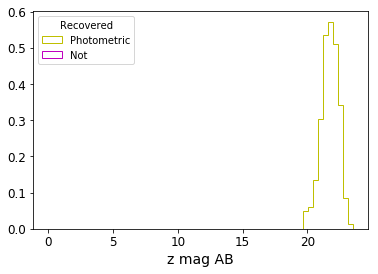

('Photometric', ' 104')
('Not', ' 3')


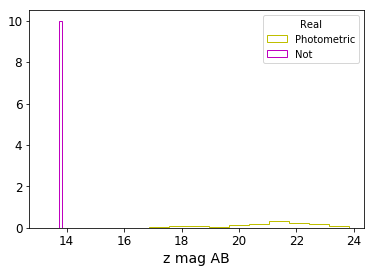

In [40]:
def indices2bool(indices,n):
    keep= np.zeros(n,bool)
    keep[indices]=True
    return keep

#Recovered
btrac= indices2bool(itrac,len(obitractor))
for bcut,lab,c in zip([cuts_obitractor['phot_z'],
                       cuts_obitractor['phot_z'] == False],
                       ['Photometric','Not'],['y','m']):
    print(lab,' %d' % len(obitractor[(btrac) & (bcut)]))
    myhist(F.tractor(obitractor.flux_z[(btrac) & (bcut)],
                     obitractor.mw_transmission_z[(btrac) & (bcut)]),
                     c=c,lab=lab)
plt.legend(title='Recovered')
plt.xlabel('z mag AB')
plt.show()

#Real
btrac= indices2bool(not_itrac,len(obitractor))
for bcut,lab,c in zip([cuts_obitractor['phot_z'],
                       cuts_obitractor['phot_z'] == False],
                       ['Photometric','Not'],['y','m']):
    print(lab,' %d' % len(obitractor[(btrac) & (bcut)]))
    myhist(F.tractor(obitractor.flux_z[(btrac) & (bcut)],
                     obitractor.mw_transmission_z[(btrac) & (bcut)],gtZero=True),
                     c=c,lab=lab)
plt.legend(title='Real')
plt.xlabel('z mag AB')
plt.show()
#plt.xlim(16,25)



### What fraction of Recovered sources are photometric? 

~ 100%

In [41]:
recovered= pd.DataFrame({
    'sim_mag':F.simcat(simcat.zflux[isim]),
    'isPhotZ':cuts_obitractor['phot_z'][isim]
})
# Bins over sim_mag
W=0.2
LO,HI=recovered['sim_mag'].min()-W,recovered['sim_mag'].max()
recovered['binc']= np.zeros(len(recovered))
for low,hi in zip(np.arange(LO,HI+W,W),np.arange(LO+W,HI+W*2,W)):
    recovered.loc[((recovered['sim_mag'] > low) &
                   (recovered['sim_mag'] <= hi)), 'binc']= (low+hi)/2
recovered.head()

isPhotZ    sim_mag       binc
0     True  21.451953  21.407456
1     True  22.592270  22.607456
2     True  21.624738  21.607456
3     True  21.212229  21.207456
4     True  21.583440  21.607456

           isPhotZ    sim_mag
binc                         
22.007456      1.0  21.980437
22.207456      1.0  22.175744
22.407456      1.0  22.390898
22.607456      1.0  22.585043
22.807456      0.5  22.764455


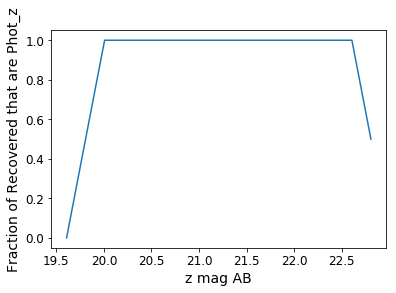

In [42]:
result= recovered.groupby('binc').sum() / recovered.groupby('binc').count()
print(result.tail(5))

plt.plot(result.index,result['isPhotZ'])
#plt.axvline(result.index[result['isPhotz'] <= 0.5][0],c='r',ls='-')
plt.xlabel('z mag AB')
plt.ylabel('Fraction of Recovered that are Phot_z')

### on object type? 

### YES
All injected galaxies have n=1 hardcoded, and doing something more complicated doesn't look like it matters becuase the fainted Recovered sources are PSF, then slightly brighter REX, then brighter EXP

('psf', ' 11')
('rex', ' 169')
('exp', ' 32')
('dev', ' 2')
('comp', ' 0')


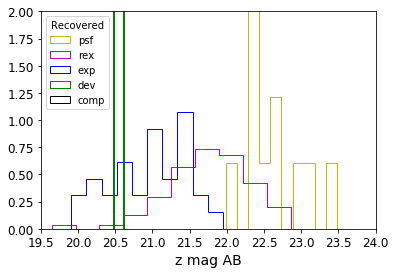

('psf', ' 25')
('rex', ' 44')
('exp', ' 26')
('dev', ' 10')
('comp', ' 2')


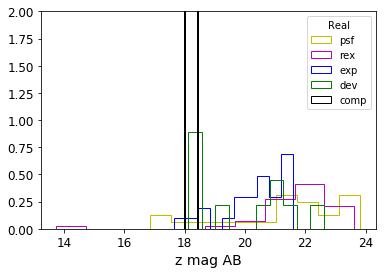

In [43]:
#Recovered 
btrac= indices2bool(itrac,len(obitractor))
for objtype,c in zip(objtypes,['y','m','b','g','k','gray']):
    isObj= (cuts_obitractor[objtype]) & (btrac)
    print(objtype,' %d' % len(obitractor[isObj]))
    myhist(F.tractor(obitractor.flux_z[isObj],
                     obitractor.mw_transmission_z[isObj],gtZero=True),
                     c=c,lab=objtype,normed=True)
plt.legend(title='Recovered')
plt.xlabel('z mag AB')
plt.ylim(0,2)
plt.xlim(19.5,24)
plt.show()

#Real
btrac= indices2bool(not_itrac,len(obitractor))
for objtype,c in zip(objtypes,['y','m','b','g','k','gray']):
    isObj= (cuts_obitractor[objtype]) & (btrac)
    print(objtype,' %d' % len(obitractor[isObj]))
    myhist(F.tractor(obitractor.flux_z[isObj],
                     obitractor.mw_transmission_z[isObj],gtZero=True),
                     c=c,lab=objtype,normed=True)
plt.legend(title='Real')
plt.xlabel('z mag AB')
plt.ylim(0,2)
plt.show()

### What fraction of injected galaxies are recovered as func of mag? 

In [44]:
fraction= pd.DataFrame({
    'sim_mag':F.simcat(simcat.zflux),
    'isRecovered':indices2bool(isim,len(simcat))
})
# Bins over sim_mag
W=0.2
LO,HI=fraction['sim_mag'].min()-W,fraction['sim_mag'].max()
fraction['binc']= np.zeros(len(fraction))
for low,hi in zip(np.arange(LO,HI+W,W),np.arange(LO+W,HI+W*2,W)):
    fraction.loc[((fraction['sim_mag'] > low) &
                   (fraction['sim_mag'] <= hi)), 'binc']= (low+hi)/2
fraction.head()

isRecovered    sim_mag       binc
0         True  21.451953  21.407456
1         True  22.592270  22.607456
2         True  21.624738  21.607456
3        False  22.330312  22.407456
4        False  20.427215  20.407456

In [45]:
result= fraction.groupby('binc').sum() / fraction.groupby('binc').count()
result.head(10)

isRecovered    sim_mag
binc                             
19.607456     1.000000  19.707456
20.007456     1.000000  19.973149
20.207456     1.000000  20.182306
20.407456     0.750000  20.411223
20.607456     1.000000  20.651827
20.807456     0.857143  20.809121
21.007456     0.833333  21.023128
21.207456     0.928571  21.183569
21.407456     0.962963  21.407248
21.607456     0.828571  21.634533

In [46]:
result.index[result['isRecovered'] <= 0.5][0]

22.807455915000986

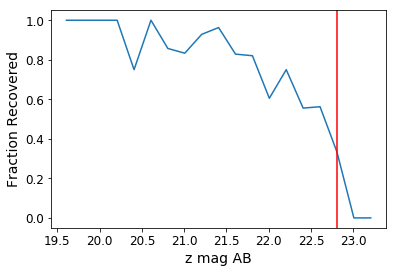

In [47]:
plt.plot(result.index,result['isRecovered'])
plt.axvline(result.index[result['isRecovered'] <= 0.5][0],c='r',ls='-')
plt.xlabel('z mag AB')
plt.ylabel('Fraction Recovered')

### Can I redo the above but one curve for each objtype?

No, can only do it for Recovered sources

### What fraction of all objects recovered is each objtype? ...basically answered that above

In [48]:
frac_recovered= fraction.iloc[isim]
for objtype in objtypes:
    frac_recovered['is'+objtype]= cuts_obitractor[objtype][itrac]
frac_recovered.head()


/home/kaylan/env_galsim/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


isRecovered    sim_mag       binc  ispsf  isrex  isexp  isdev  iscomp
0         True  21.451953  21.407456  False   True  False  False   False
1         True  22.592270  22.607456  False   True  False  False   False
2         True  21.624738  21.607456  False   True  False  False   False
5         True  21.212229  21.207456  False   True  False  False   False
6         True  21.583440  21.607456  False   True  False  False   False

In [49]:
result= frac_recovered.groupby('binc').sum() / frac_recovered.groupby('binc').count()
result.head()

isRecovered    sim_mag  ispsf     isrex     isexp  isdev  iscomp
binc                                                                       
19.607456          1.0  19.707456    0.0  1.000000  0.000000    0.0     0.0
20.007456          1.0  19.973149    0.0  0.250000  0.750000    0.0     0.0
20.207456          1.0  20.182306    0.0  0.000000  1.000000    0.0     0.0
20.407456          1.0  20.405893    0.0  0.666667  0.333333    0.0     0.0
20.607456          1.0  20.651827    0.0  0.500000  0.500000    0.0     0.0

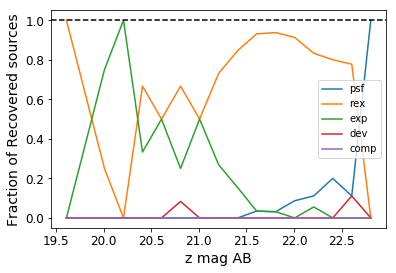

In [50]:
for objtype,c in zip(objtypes,['y','m','b','g','cyan']):
    plt.plot(result.index,result['is'+objtype],label=objtype)
plt.axhline(1,c='k',ls='--')
plt.legend()
#plt.axvline(result.index[result['isRecovered'] <= 0.5][0],c='r',ls='-')
plt.xlabel('z mag AB')
plt.ylabel('Fraction of Recovered sources')

## What do recovered and missed sources look like?

In [51]:
# First 1 CCD
type(obi_z[0,0])

numpy.float32

In [52]:
from PIL import Image, ImageDraw  


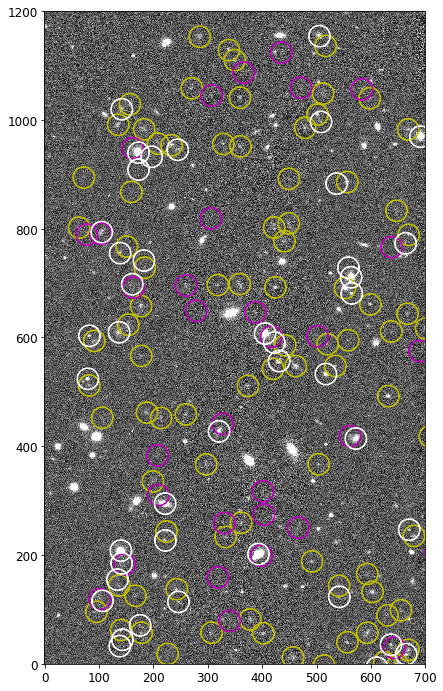

In [54]:
xslc,yslc= slice(2500,3200),slice(2300,3500) 
fig,ax=plt.subplots(figsize=(8,12))

plot_image(ax,obi_z[xslc,yslc])
# Recovered
plot_xy(ax,xs=obitractor.bx[itrac]-yslc.start,ys=obitractor.by[itrac]-xslc.start,
        color='y',r_pixels=5/0.262)
# Missed 
plot_xy(ax,xs=simcat.x[not_isim]-yslc.start,ys=simcat.y[not_isim]-xslc.start,
        color='m',r_pixels=5/0.262)
# Real
plot_xy(ax,xs=obitractor.bx[not_itrac]-yslc.start,ys=obitractor.by[not_itrac]-xslc.start,
        color='w',r_pixels=5/0.262)

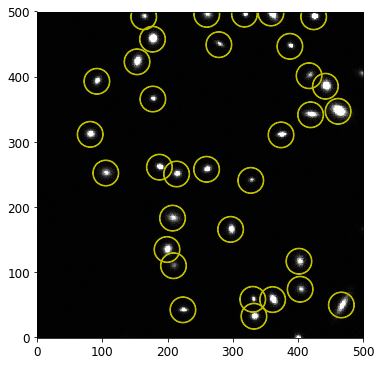

In [77]:
fig,ax=plt.subplots(figsize=(12,6))
xslc,yslc= slice(2500,3000), slice(2500,3000)
plot_image(ax,diff[xslc,yslc])
x,y= justInSlice(simcat.x,simcat.y,xslc,yslc)
plot_xy(ax,xs=x-xslc.start,ys=y-yslc.start,
        color='y',r_pixels=5/0.262)

In [172]:
import itertools

In [176]:
def fill_cutout(cutout,hw):
    filled= np.zeros((hw*2,hw*2))
    filled[0:cutout.shape[0],0:cutout.shape[1]]= cutout
    return filled

class Panel(object):
    """Plots panel of N cutouts for N sources from an image and any slice into it
    
    TODO: normalize each cutout before adding it to the panel
    
    Args:
        img: full image
        x_all,y_all: positions of all sources in the full image
        xslc,yslc: slice() objects if want to take subset of full image and sources
        hw: half-width [pixels]                                                                                                                          
        nrows: number of rows and also number of cols
        
    Returns:
        panel:
        panel
    """         
    def __init__(self,img,x_all,y_all,
                 xslc=None,yslc=None,
                 nrows=2,hw=30):          
        dims = (nrows*hw*2,nrows*hw*2)
        self.panel= np.zeros(dims)
        self.xpan= np.arange(0, dims[0], hw*2, dtype=int)
        self.ypan = np.arange(0, dims[1], hw*2, dtype=int)
        
        if xslc is None:
            xslc=slice(0,img.shape[0])
        if yslc is None:
            yslc=slice(0,img.shape[1])
        pil_img= Image.fromarray(img[xslc,yslc])
        x_inslice,y_inslice= justInSlice(x_all,y_all,xslc,yslc)
        print(len(x_inslice),nrows**2)
        npanels= min(nrows**2,len(x_inslice))
        i=0
        self.x,self.y=[],[]
        for yp,xp in itertools.product(self.ypan,self.xpan):
                xs,ys=x_inslice[i]-xslc.start,y_inslice[i]-yslc.start
                cutout= pil_img.crop((xs-hw,ys-hw,xs+hw,ys+hw))
                self.panel[xp:xp+2*hw, yp:yp+2*hw]= cutout
                # retain exact position
                self.x.append(xp+ hw + xs-int(xs))
                self.y.append(yp+ hw + ys-int(ys))
                i+=1
                if i >= npanels:
                    break
    
    def plot(self):
        fig,ax=plt.subplots(figsize=(7,7))
        plot_image(ax,self.panel,flip_xy=False)
        plot_xy(ax,xs=np.array(self.x),ys=np.array(self.y),
                color='y',r_pixels=5/0.262,flip_xy=False)
        # borders
        for xp,yp in zip(self.xpan[1:],self.ypan[1:]):
            ax.axvline(xp,c='y')
            ax.axhline(yp,c='y')
            

(107, 100)


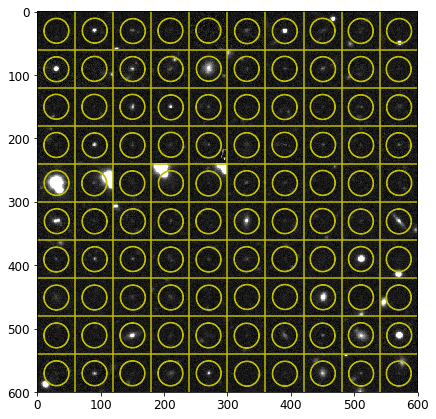

In [174]:
xslc,yslc= None,None #slice(2500,3200),slice(2300,3500) 
p= Panel(obi_z,obitractor.bx[not_itrac],obitractor.by[not_itrac],
         xslc=xslc,yslc=yslc,
         hw=30,nrows=10)
p.plot()

(214, 100)


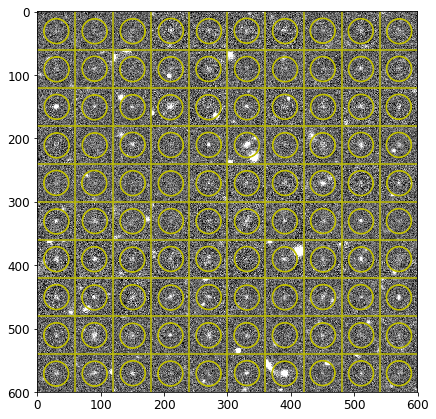

In [175]:
xslc,yslc= None,None #slice(2500,3200),slice(2300,3500) 
p= Panel(obi_z,obitractor.bx[itrac],obitractor.by[itrac],
         xslc=xslc,yslc=yslc,
         hw=30,nrows=10)
p.plot()

(33, 100)


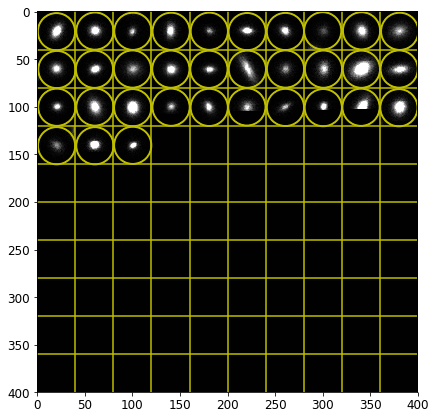

In [177]:
p= Panel(diff,simcat.x,simcat.y,
         xslc=slice(2500,3000),yslc=slice(2500,3000),
         hw=20,nrows=10)
p.plot()